# Marketing Campaign Analysis

In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Step 1: Load the Data from the ZIP File
zip_file_path = 'Marketing Campaign.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Inspect the contents of the ZIP file
    print("Files in the ZIP archive:")
    for file in zip_ref.namelist():
        print(file)
    
    # Load the train dataset (you can change to 'test.csv' if needed)
    csv_file_name = 'train.csv'  # Load the training data
    df = pd.read_csv(zip_ref.open(csv_file_name))

# Step 2: Basic Data Exploration
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Information:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

Files in the ZIP archive:
test.csv
train.csv

First 5 rows of the dataset:
          id target  day month  duration  contactId  age  gender         job  \
0  432148809     no   27   may       166        623   30  female      worker   
1  432184318     no   26   oct       183       1992   42  female     manager   
2  432182482     no    5   jun       227       2778   26  female    services   
3  432150520     no    2   jun        31       3070   34    male  unemployed   
4  432145870     no   15   may      1231       6583   48    male      worker   

  maritalStatus        education creditFailure  accountBalance house credit  \
0       married       highSchool            no            -202    no     no   
1       married     uniGraduated            no            2463    no     no   
2        single       highSchool            no            2158   yes    yes   
3      divorced     uniGraduated           yes              75   yes     no   
4       married  secondarySchool            no   

In [3]:
# Step 3: Data Cleaning
# 3.1: Handle Missing Values
print("\nChecking for missing values in key columns...")
missing_columns = ['id', 'target']
for col in missing_columns:
    if col in df.columns:
        print(f"{col} - Missing Values: {df[col].isnull().sum()}")

# Drop rows with missing id and target values
df.dropna(subset=['id'], inplace=True)  # Keep rows where 'id' is not null
df.dropna(subset=['target'], inplace=True)  # Keep rows where 'target' is not null
print(f"Rows after dropping missing target values: {df.shape[0]}")

# 3.2: Handle Negative Values
# Check and handle negative values in accountBalance
if 'accountBalance' in df.columns:
    negative_balance_count = (df['accountBalance'] < 0).sum()
    print(f"Negative account balance values: {negative_balance_count}")
    df = df[df['accountBalance'] >= 0]  # Remove negative account balances

# 3.3: Remove Duplicate Rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
df.drop_duplicates(inplace=True)

# 3.4: Convert Data Types
if 'id' in df.columns:
    df['id'] = df['id'].astype(int)  # Convert id to integer


Checking for missing values in key columns...
id - Missing Values: 0
target - Missing Values: 0
Rows after dropping missing target values: 31480
Negative account balance values: 2668
Number of duplicate rows: 0


In [4]:
# Step 4: Extract Date Features and RFM Calculation
# Here we're assuming you have a valid date column in your dataset.
# Create 'invoice_date' based on 'day' and 'month'
if 'day' in df.columns and 'month' in df.columns:
    month_dict = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    
    # Create a new 'invoice_date'
    df['invoice_date'] = pd.to_datetime(df['day'].astype(str) + ' ' + df['month'].map(month_dict).astype(str) + ' 2023', errors='coerce')
    
    reference_date = df['invoice_date'].max() + pd.Timedelta(days=1)

    # RFM Calculation
    rfm = df.groupby('contactId').agg({
        'invoice_date': lambda x: (reference_date - x.max()).days,  # Recency
        'target': 'count',  # Frequency
        'accountBalance': 'sum'  # Monetary Value
    }).reset_index()

    # Rename columns to appropriate RFM labels
    rfm.rename(columns={
        'invoice_date': 'Recency',
        'target': 'Frequency',
        'accountBalance': 'MonetaryValue'
    }, inplace=True)

    print("\nRFM Analysis Sample:")
    print(rfm.head())
else:
    print("Warning: 'day' or 'month' columns do not exist.")

C:\Users\milto\AppData\Local\Temp\ipykernel_13412\669711658.py:12: UserWarning: Parsing dates in %d %m %Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['invoice_date'] = pd.to_datetime(df['day'].astype(str) + ' ' + df['month'].map(month_dict).astype(str) + ' 2023', errors='coerce')



RFM Analysis Sample:
   contactId  Recency  Frequency  MonetaryValue
0       1992       67          1           2463
1       2778      210          1           2158
2       3070      213          1             75
3       6583      231          1            559
4      24232      225          1           5729



Summary Statistics:
Total Revenue: 43293800
Average Revenue: 1502.891658277502
Number of Unique Customers: 28807

Normalized RFM Data Sample:
    Recency  Frequency  MonetaryValue
0 -1.668085  -0.013176       0.313577
1  0.212182  -0.013176       0.213962
2  0.251628  -0.013176      -0.466358
3  0.488305  -0.013176      -0.308280
4  0.409413  -0.013176       1.380272


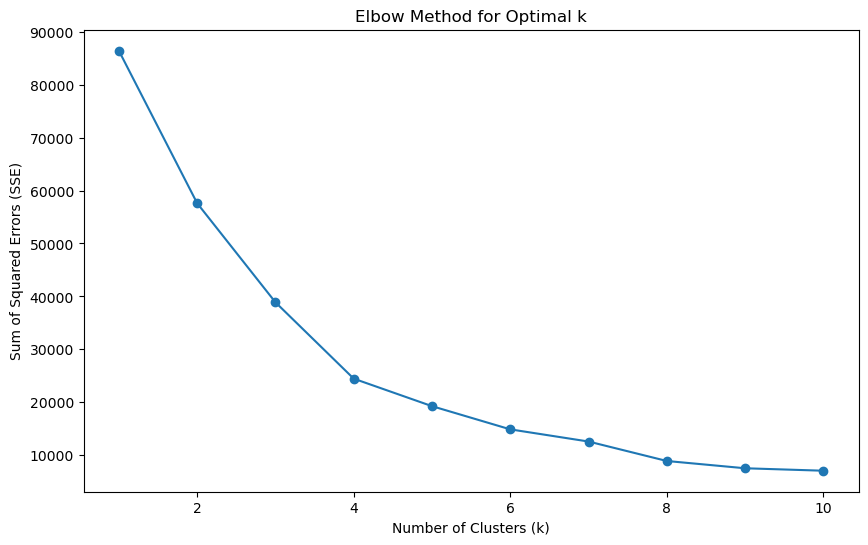

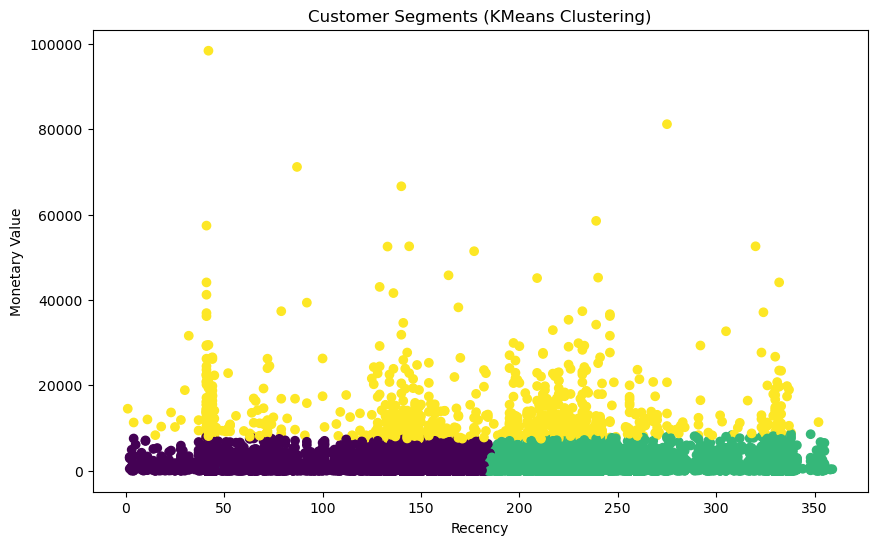

In [5]:
# Step 5: Summary Statistics from RFM
if 'rfm' in locals() and isinstance(rfm, pd.DataFrame):
    total_revenue = rfm['MonetaryValue'].sum()
    average_revenue = rfm['MonetaryValue'].mean()
    unique_customers = rfm['contactId'].nunique()

    print("\nSummary Statistics:")
    print(f"Total Revenue: {total_revenue}")
    print(f"Average Revenue: {average_revenue}")
    print(f"Number of Unique Customers: {unique_customers}")

    # Step 6: Data Normalization
    features = rfm[['Recency', 'Frequency', 'MonetaryValue']]
    scaler = StandardScaler()
    rfm_normalized = scaler.fit_transform(features)

    print("\nNormalized RFM Data Sample:")
    print(pd.DataFrame(rfm_normalized, columns=['Recency', 'Frequency', 'MonetaryValue']).head())

    # Step 7: KMeans Clustering
    sse = []  # Sum of squared errors for each k
    k_range = range(1, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(rfm_normalized)
        sse.append(kmeans.inertia_)

    # Plotting the Elbow Method
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.show()

    # Fit KMeans with chosen number of clusters
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_normalized)

    # Visualize KMeans Clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(rfm['Recency'], rfm['MonetaryValue'], c=rfm['KMeans_Cluster'], cmap='viridis')
    plt.xlabel('Recency')
    plt.ylabel('Monetary Value')
    plt.title('Customer Segments (KMeans Clustering)')
    plt.show()
else:
    print("RFM data is not available for further analysis.")